# DTSA - 5511 Deeplearning - Week 5 Kaggle Challenge
## GAN Getting Started - Monet paintings
### https://www.kaggle.com/competitions/gan-getting-started/

This notebook contains the code for the Week 5 Kaggle Gan getting started project

The objective of this project is to generate Monet style painting images using Generative Adversarial Networks

#### From the Kaggle Project description

**The Challenge:**

A GAN consists of at least two neural networks: a generator model and a discriminator model. The generator is a neural network that creates the images. For our competition, you should generate images in the style of Monet. This generator is trained using a discriminator.

The two models will work against each other, with the generator trying to trick the discriminator, and the discriminator trying to accurately classify the real vs. generated images.

Your task is to build a GAN that generates 7,000 to 10,000 Monet-style images.

**Dataset description**

The dataset contains four directories: monet_tfrec, photo_tfrec, monet_jpg, and photo_jpg. The monet_tfrec and monet_jpg directories contain the same painting images, and the photo_tfrec and photo_jpg directories contain the same photos.

The monet directories contain Monet paintings. Use these images to train your model.

The photo directories contain photos. Add Monet-style to these images and submit your generated jpeg images as a zip file. Other photos outside of this dataset can be transformed but keep your submission file limited to 10,000 images.

Note: Monet-style art can be created from scratch using other GAN architectures like DCGAN. The submitted image files do not necessarily have to be transformed photos.

**Files**

`monet_jpg` - 300 Monet paintings sized 256x256 in JPEG format

`monet_tfrec` - 300 Monet paintings sized 256x256 in TFRecord format

`photo_jpg` - 7028 photos sized 256x256 in JPEG format

`photo_tfrec` - 7028 photos sized 256x256 in TFRecord format


#### Get the data  
Copy and Unzip files from Google drive
The zip data file was earlier copied from the Kaggle project `gan-getting-started` dataset to my personal google drive. [Instructions on using the Kaggle API can be found here](https://towardsdatascience.com/downloading-kaggle-datasets-directly-into-google-colab-c8f0f407d73a)

In [1]:
# Complete path to storage location of the .zip file of data
# Mount google drive
import os
from google.colab import drive
drive.mount('/gdrive')

zip_path = '/gdrive/MyDrive/kaggle/gan-getting-started.zip'
# Check current directory (be sure you're in the directory where Colab operates: '/content')
print(os.getcwd())
# Copy the .zip file into the present directory
!cp '{zip_path}' .
# Unzip quietly
!unzip -q 'gan-getting-started.zip'
# View the unzipped contents in the virtual machine

Mounted at /gdrive
/content


In [2]:
import os
os.listdir()

['.config',
 'monet_tfrec',
 'photo_jpg',
 'gan-getting-started.zip',
 'monet_jpg',
 'photo_tfrec',
 'sample_data']

In [49]:
tf.config.run_functions_eagerly(False)


##### Import all required libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import (
    layers,
    models,
    optimizers,
    callbacks,
    utils,
    metrics,
    regularizers,
    losses,
    backend as k,
    preprocessing,
)

from tensorflow.keras.preprocessing.image import ImageDataGenerator
print(tf.__version__)

2.15.0


## Exploratory Data Analysis

### Read the Train painting images

*Note: The image files are given in .jpeg and TFRecords formats. We will use the jpeg format files for this project*

In [4]:
print(len(os.listdir('./monet_jpg')))
print(len(os.listdir('./photo_jpg')))

300
7038


#### Process the image data

In [93]:
train_path = './monet_jpg'
train_class = 'monet_jpg'
IMAGE_SIZE = (128,128)
BATCH_SIZE = 12
images_ds = keras.utils.image_dataset_from_directory(
    "monet_jpg", label_mode=None, image_size=IMAGE_SIZE, batch_size=BATCH_SIZE
)
images_ds = images_ds.map(lambda x: x / 255.0)
#images_ds = images_ds.prefetch(tf.data.AUTOTUNE)

photo_images_ds = keras.utils.image_dataset_from_directory(
    "photo_jpg", label_mode=None, image_size=IMAGE_SIZE, batch_size=BATCH_SIZE
)
photo_images_ds = photo_images_ds.map(lambda x: x / 255.0)
#photo_images_ds = photo_images_ds.prefetch(tf.data.AUTOTUNE)


Found 300 files belonging to 1 classes.
Found 7038 files belonging to 1 classes.


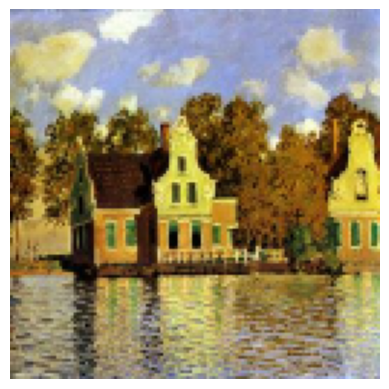

In [94]:
for x in images_ds:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break

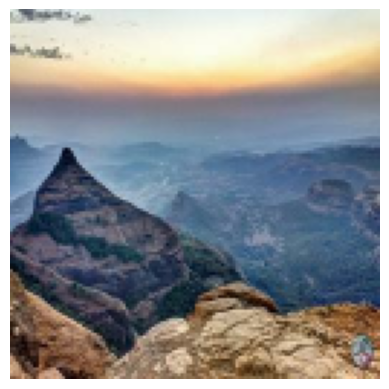

In [95]:
for x in photo_images_ds:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break

## Build the GAN

First we will build the discrimator which will take the monet painting images as input

In [96]:
discriminator_input = layers.Input(shape=[128,128,3])
y = layers.Conv2D(64, 4, strides=2, padding='same')(discriminator_input)
y = layers.LeakyReLU(0.2)(y)
y = layers.Dropout(0.3)(y)

y = layers.Conv2D(128, 4, strides=2, padding='same')(y)
y = layers.BatchNormalization(momentum=0.9)(y)
y = layers.LeakyReLU(0.2)(y)
y = layers.Dropout(0.3)(y)

y = layers.Conv2D(256, 4, strides=2, padding='same')(y)
y = layers.BatchNormalization(momentum=0.9)(y)
y = layers.LeakyReLU(0.2)(y)
y = layers.Dropout(0.3)(y)

y = layers.Conv2D(512, 4, strides=2, padding='same')(y)
y = layers.BatchNormalization(momentum=0.9)(y)
y = layers.LeakyReLU(0.2)(y)
y = layers.Dropout(0.3)(y)

y = layers.Conv2D(1, 8, strides=1, padding='valid', use_bias=False, activation='sigmoid')(y)
discriminator_output = layers.Flatten()(y)

discriminator = models.Model(inputs=discriminator_input, outputs=discriminator_output, name='discriminator')

#discriminator.build(input_shape=[None, 96, 96, 3])
discriminator.summary()



Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_73 (Conv2D)          (None, 64, 64, 64)        3136      
                                                                 
 leaky_re_lu_46 (LeakyReLU)  (None, 64, 64, 64)        0         
                                                                 
 dropout_36 (Dropout)        (None, 64, 64, 64)        0         
                                                                 
 conv2d_74 (Conv2D)          (None, 32, 32, 128)       131200    
                                                                 
 batch_normalization_37 (Ba  (None, 32, 32, 128)       512       
 tchNormalization)                                               
                                                     

**Next we will define the generator model using the photo images as input**

In [97]:
latent_dim = 1024
generator_input = layers.Input(shape=(latent_dim,))
#generator.add(layers.Input(shape=(latent_dim,)))
x = layers.Reshape((1, 1, latent_dim))(generator_input)

x = layers.Conv2DTranspose(512, 4, strides=1, padding='valid', use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2DTranspose(256, 4, strides=2, padding='same', use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2DTranspose(128, 4, strides=2, padding='same', use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2DTranspose(64, 4, strides=2, padding='same', use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2DTranspose(32, 3, strides=2, padding='same', use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)

generator_output = layers.Conv2DTranspose(3, 4, strides=2, padding='same', use_bias=False, activation='tanh')(x)

generator = models.Model(inputs=generator_input, outputs=generator_output,name='generator')

generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 1024)]            0         
                                                                 
 reshape_2 (Reshape)         (None, 1, 1, 1024)        0         
                                                                 
 conv2d_transpose_12 (Conv2  (None, 4, 4, 512)         8388608   
 DTranspose)                                                     
                                                                 
 batch_normalization_40 (Ba  (None, 4, 4, 512)         2048      
 tchNormalization)                                               
                                                                 
 leaky_re_lu_50 (LeakyReLU)  (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose_13 (Conv2  (None, 8, 8, 256)         20

### Create a GAN keras.model sub-class ###

Add discrimator and generator models and override the `train_step` method

In [98]:
class GAN(models.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN,self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim


    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile(run_eagerly=True)
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")
        self.seed_generator = 1
        self.d_real_acc_metric = metrics.BinaryAccuracy(name="d_real_acc")
        self.d_fake_acc_metric = metrics.BinaryAccuracy(name="d_fake_acc")
        self.d_acc_metric = metrics.BinaryAccuracy(name="d_acc")
        self.g_acc_metric = metrics.BinaryAccuracy(name="g_acc")

    @property
    def metrics(self):
        return [
            self.d_loss_metric,
            self.g_loss_metric,
            self.d_real_acc_metric,
            self.d_fake_acc_metric,
            self.d_acc_metric,
            self.g_loss_metric,
            self.g_acc_metric
            ]

    def train_step(self, real_images):
        # Sample random points in the latent space
            batch_size = tf.shape(real_images)[0]
            #print(batch_size)
            random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
            # Decode them to fake
            generated_images = self.generator(
                      random_latent_vectors, training=True
            )

            real_predictions = self.discriminator(real_images, training=True)

            fake_predictions = self.discriminator(
                generated_images, training=True
            )

            real_labels = tf.ones_like(real_predictions)
            real_noisy_labels = real_labels + 0.1 * tf.random.uniform(
                tf.shape(real_predictions)
            )
            fake_labels = tf.zeros_like(fake_predictions)
            fake_noisy_labels = fake_labels - 0.1 * tf.random.uniform(
                tf.shape(fake_predictions)
            )

            d_real_loss = self.loss_fn(real_noisy_labels, real_predictions)
            d_fake_loss = self.loss_fn(fake_noisy_labels, fake_predictions)

            d_loss = (d_real_loss + d_fake_loss) / 2.0

            g_loss = self.loss_fn(fake_labels, fake_predictions)

            # Update metrics
            self.d_loss_metric.update_state(d_loss)
            self.d_real_acc_metric.update_state(real_labels, real_predictions)
            self.d_fake_acc_metric.update_state(fake_labels, fake_predictions)
            self.d_acc_metric.update_state(
                [real_labels, fake_labels], [real_predictions, fake_predictions]
            )
            self.g_loss_metric.update_state(g_loss)
            self.g_acc_metric.update_state(real_labels, real_predictions)

            return {m.name: m.result() for m in self.metrics}

**Next we will compile and train the model passing the painting images as input**

*Note: Because there are only 300 painting images provided, we will shuffle and repeat the images epoch times steps per epoch. This will give us a large enough training dataset to train the models on*

In [100]:
epochs = 50  # In practice, use ~100 epochs
steps = 100  # In practice, use ~100 steps per epoch
latent_dim = 1024  # Number of random points in the latent space to generate images from

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)

gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

train_images_ds = images_ds.shuffle(
  BATCH_SIZE, seed=1, reshuffle_each_iteration=True).repeat(epochs * steps)
#images_ds = images_ds.batch(BATCH_SIZE, drop_remainder=True)

gan.fit(train_images_ds, epochs=epochs, steps_per_epoch=steps)

Epoch 1/50
100/100 [==============================] - 6s 63ms/step - d_loss: 0.8354 - g_loss: 0.8925 - d_real_acc: 0.5442 - d_fake_acc: 0.4608 - d_acc: 0.5025 - g_acc: 0.5442
Epoch 2/50
100/100 [==============================] - 6s 63ms/step - d_loss: 0.8097 - g_loss: 0.8789 - d_real_acc: 0.5450 - d_fake_acc: 0.4633 - d_acc: 0.5042 - g_acc: 0.5450
Epoch 3/50
100/100 [==============================] - 6s 62ms/step - d_loss: 0.8202 - g_loss: 0.8985 - d_real_acc: 0.5425 - d_fake_acc: 0.4550 - d_acc: 0.4988 - g_acc: 0.5425
Epoch 4/50
100/100 [==============================] - 6s 63ms/step - d_loss: 0.8167 - g_loss: 0.8809 - d_real_acc: 0.5367 - d_fake_acc: 0.4442 - d_acc: 0.4904 - g_acc: 0.5367
Epoch 5/50
100/100 [==============================] - 6s 63ms/step - d_loss: 0.8333 - g_loss: 0.9162 - d_real_acc: 0.5450 - d_fake_acc: 0.4417 - d_acc: 0.4933 - g_acc: 0.5450
Epoch 6/50
100/100 [==============================] - 6s 63ms/step - d_loss: 0.8101 - g_loss: 0.8683 - d_real_acc: 0.5467 - d

### Generate new images ###


To create painting images from the photo images we will first transform the photo image data using convolutional layers to match the same shape as the random input to the generator model. The generator will take the image data and generate images in the monet painting style

In [111]:
test_input = layers.Input(shape=[128,128,3])
z = layers.Conv2D(16, 4, strides=2, padding='valid')(test_input)
z = layers.Conv2D(32, 4, strides=2, padding='same')(z)
z = layers.Conv2D(64, 4, strides=2, padding='same')(z)
z = layers.Conv2D(128, 4, strides=2, padding='same')(z)
z = layers.Conv2D(256, 4, strides=2, padding='same')(z)
z = layers.Conv2D(512, 4, strides=2, padding='same')(z)
z = layers.Conv2D(1024, 4, strides=2, padding='same')(z)
test_output = layers.Flatten()(z)
test_model = models.Model(inputs=test_input, outputs=test_output, name='test_model')
test_model.summary()

Model: "test_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_92 (Conv2D)          (None, 63, 63, 16)        784       
                                                                 
 conv2d_93 (Conv2D)          (None, 32, 32, 32)        8224      
                                                                 
 conv2d_94 (Conv2D)          (None, 16, 16, 64)        32832     
                                                                 
 conv2d_95 (Conv2D)          (None, 8, 8, 128)         131200    
                                                                 
 conv2d_96 (Conv2D)          (None, 4, 4, 256)         524544    
                                                                 
 conv2d_97 (Conv2D)          (None, 2, 2, 512)         2

In [112]:
test_model.compile(loss=keras.losses.MeanSquaredError())
test_output = test_model.predict(photo_images_ds, batch_size=BATCH_SIZE)
test_output.shape

587/587 [==============================] - 2s 3ms/step


(7038, 1024)

In [113]:
grid_width, grid_height = (10, 3)
#z_sample = np.random.normal(size=(grid_width * grid_height, latent_dim))
#z_input = tf.data.Dataset.photo_images_ds
generated_images = generator.predict(test_output)
generated_images.shape

220/220 [==============================] - 1s 3ms/step


(7038, 128, 128, 3)

(7038, 128, 128, 3)


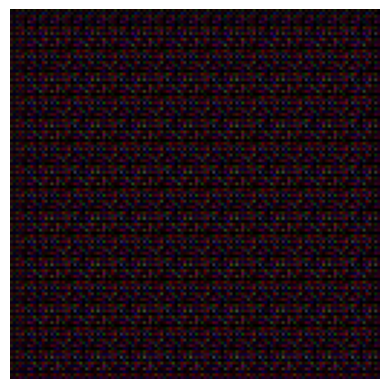

In [114]:
print(generated_images.shape)
plt.axis("off")
plt.imshow((generated_images[0] * 255).astype("int32"))


## Save the generated images and submit zipped image files to Kaggle project##

In [117]:
for i, image in enumerate(generated_images):
    plt.savefig(f'generated_images/image_{i}.png', bbox_inches='tight', pad_inches=0)


<Figure size 640x480 with 0 Axes>

In [118]:
!zip -r images.zip /content/generated_images

Streaming output truncated to the last 5000 lines.
  adding: content/generated_images/image_2651.png (deflated 90%)
  adding: content/generated_images/image_3583.png (deflated 90%)
  adding: content/generated_images/image_3518.png (deflated 90%)
  adding: content/generated_images/image_1429.png (deflated 90%)
  adding: content/generated_images/image_1411.png (deflated 90%)
  adding: content/generated_images/image_4551.png (deflated 90%)
  adding: content/generated_images/image_2342.png (deflated 90%)
  adding: content/generated_images/image_5972.png (deflated 90%)
  adding: content/generated_images/image_3272.png (deflated 90%)
  adding: content/generated_images/image_5205.png (deflated 90%)
  adding: content/generated_images/image_5967.png (deflated 90%)
  adding: content/generated_images/image_5475.png (deflated 90%)
  adding: content/generated_images/image_5088.png (deflated 90%)
  adding: content/generated_images/image_6223.png (deflated 90%)
  adding: content/generated_images/imag

In [119]:
os.listdir()

['.config',
 'monet_tfrec',
 'photo_jpg',
 'generated_images',
 'generated_images.zip',
 'gan-getting-started.zip',
 'monet_jpg',
 'photo_tfrec',
 'sample_data']

In [123]:
!cp images.zip /gdrive/MyDrive/kaggle/images.zip

In [125]:
os.listdir('/gdrive/MyDrive/kaggle')


['histopathologic-cancer-detection.zip',
 'nlp-getting-started.zip',
 'images.zip',
 'planttraits2024.zip',
 'kaggle.json',
 'week3_submission.csv',
 'week4_submission.csv',
 'learning-agency-lab-automated-essay-scoring-2.zip',
 'model2.keras',
 'model_8.keras',
 'model_9.keras',
 'model_final.keras',
 'model.keras',
 'model_0619.keras',
 'model_0621.keras',
 'submission.csv']

In [127]:
os.chdir('/gdrive/MyDrive/kaggle')
os.listdir()

['histopathologic-cancer-detection.zip',
 'nlp-getting-started.zip',
 'images.zip',
 'planttraits2024.zip',
 'kaggle.json',
 'week3_submission.csv',
 'week4_submission.csv',
 'learning-agency-lab-automated-essay-scoring-2.zip',
 'model2.keras',
 'model_8.keras',
 'model_9.keras',
 'model_final.keras',
 'model.keras',
 'model_0619.keras',
 'model_0621.keras',
 'submission.csv',
 'gan-getting-started.zip']

In [133]:
!kaggle competitions submit gan-getting-started -f images.zip -m "First submission DTSA5511"

100% 2.94M/2.94M [00:02<00:00, 1.32MB/s]
400 - Bad Request - Submission not allowed:  This competition only accepts Submissions from Notebooks.


In [131]:
os.getcwd()

'/gdrive/MyDrive/kaggle'

In [132]:
os.environ['KAGGLE_CONFIG_DIR'] = '/gdrive/MyDrive/kaggle'